<H1 align="center"> Cross-View Gait Recognition Based on U-Net</H1>

<H5 align="right"> Updated on Nov 23, 2020</H5>

---

Inspired by the great successes of GANs in image translation tasks, we propose a new gait recognition technique by using a conditional generative model to generate view-invariant features. The proposed method is evaluated on one of the largest datasets available under the variations of view, clothing and carrying conditions: CASIA gait database B. Experimental results show that the proposed method achieves an outstanding correct classification rate and outperformed state-of-the-art methods specially in carrying-bag and wearing-coat sequences. 


First, we are going to clone some repositories to download the dataset that is going to be used to train and test our model. [**CASIA-B**](http://www.cbsr.ia.ac.cn/english/Gait%20Databases.asp) is one of the largest datasets available for benchmarking gait recognition techniques, which has been collected by The Institute of Automation Chinese Academy of Sciences. This dataset is composed of 124 subjects captured from 11 views. 

There are two ways to complete this step:
- Option 1: Download the raw dataset and preprocess it (~ 30 min).
- Option 2: Download the prepocessed dataset (~ 2 min).



# DATA PREPARATION

In [ ]:
# First, let's create some directories to store the images
!mkdir -p CASIA/DatasetB/silhouettes                                              # Folder for original images (CASIA-B) 
!mkdir CASIA/sil                                                                  # Folder for processed images (GEI representations)
!mkdir -p CASIA/pix2pix/inputdata CASIA/pix2pix/targetdata CASIA/pix2pix/outputs  # The folders where images used to train the GAN are going to be stored

## Option 1: Download the raw dataset and preprocess it 

In [ ]:
# %%capture
# Let's clone our repository
!git clone https://gitlab.com/IsRaTiAl/gait.git

# The following code will let us get our dataset in raw format, so it will be necessary to preprocess it (croping and normalization)
!git clone https://github.com/chentinghao/download_google_drive.git
!python ./download_google_drive/download_gdrive.py 1Lx1Ltc7UiDjTDXjMjW9tFdgwtR64dhuh gait/GaitDatasetB-silh.zip
!unzip gait/GaitDatasetB-silh.zip

Then, some directories will be created where the dataset is going to be extracted (this may take ~5 minutes).

In [ ]:
import tarfile
from glob import glob
import shutil

from glob import glob
for i in range(1,125):
  if(i%10 == 0):
    print('Extracting Subjects: '+str(i).zfill(3)+ '...'+str(i+1).zfill(3))
  tf = tarfile.open('GaitDatasetB-silh/'+str(i).zfill(3)+'.tar.gz')
  tf.extractall('CASIA/DatasetB/silhouettes/')

Extracting Subject: 010...
Extracting Subject: 020...
Extracting Subject: 030...
Extracting Subject: 040...
Extracting Subject: 050...
Extracting Subject: 060...
Extracting Subject: 070...
Extracting Subject: 080...
Extracting Subject: 090...
Extracting Subject: 100...
Extracting Subject: 110...
Extracting Subject: 120...


### Normalization
In this part of the code, the silhouettes are extracted and normalized, see the figure below. A simple background extraction is performed to find the silhouette in each image. Then, some image transformations such as resizing, thresholding, and cropping are applied to normalize our images and create the GEI image representation (this might take ~15 min). 
<figure>
<center>
<img src='https://gitlab.com/IsRaTiAl/gait/raw/master/Images/Image1.svg'/>
<figcaption>Normalization example</figcaption></center>
</figure>

In [ ]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
import matplotlib.pyplot as plt


def GEI_generator(sil_file, size = 64,debug = False):
  lfiles = os.listdir(sil_file)
  lfiles.sort()
  stack_GEI = []
  if debug:
    plt.figure(figsize=(20,int(len(lfiles)/10)))
  for idimg, path in enumerate(lfiles):
    if debug: plt.subplot((len(lfiles)/15)+1,15, idimg+1)
    img = cv2.imread(sil_file+path,0)
    # Silhouette extraction
    contours1,_ = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img,contours1,-1,255,-1)

    if (len(contours1)>0):
      ncoun= np.concatenate(contours1)[:,0,:]
      x1, y1 = np.min(ncoun,axis=0)
      x2, y2 = np.max(ncoun,axis=0)
      silhouette = img[y1:y2,x1:x2]

      # Normalizae silhouette
      factor = size/max(silhouette.shape)
      height = round(factor*silhouette.shape[0])
      width = round(factor*silhouette.shape[1])
      if(height>width):
        nor_sil = cv2.resize(silhouette,(width,height))
#         print(nor_sil.shape)
        # We add a background of the shape size x size
        portion_body = 0.3                                                      # We take the upper part of the body to center the image and avoid the legs
        moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
        w = round(moments['m10']/moments['m00'])
        background = np.zeros((size, size))
        shift = round((size/2)-w)
#         print('center:',w,' shift:',shift)
        if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
        background[:,shift:nor_sil.shape[1]+shift] = nor_sil

        stack_GEI.append(background)
        if debug:
          plt.xticks([])
          plt.yticks([])
          plt.imshow(background,'gray')
          # plt.subplots_adjust(wspace=0.05, hspace=0.01)
  if stack_GEI == []:
    GEI = np.zeros((size, size))
    print('\tNo Files Found')
  else: 
    GEI = np.mean(np.array(stack_GEI),axis=0)
    
  return GEI, stack_GEI

Let's probe our function with the subject 33 from our dataset in normal conditions. Notice that we are showing each silhouette in the sequence, and at the end of the sequence the corresponding GEI image.

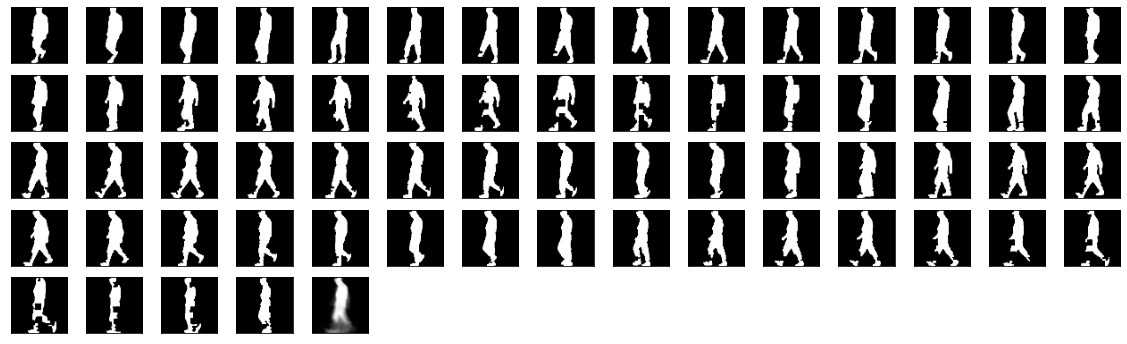

In [ ]:
seq_dir = 'CASIA/DatasetB/silhouettes/033/nm-01/072/'
gGEI,_ = GEI_generator(seq_dir, 64, debug=True)
plt.imshow(gGEI, 'gray')

As it can be seen above, our normalization function is working correctly, so let's process the sequences corresponding to the 124 subjects within the dataset. This is a repeatable iteration, so it could take 10 minutes to process all the sequences.

In [ ]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
t0 = time.clock()

# Define the directories 
data_base = 'CASIA'
data_set = 'DatasetB'
data_set_rep = 'sil'
directorio = 'silhouettes'
condition = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
formato = '.png'
slash='/'

altura_maxima = 64
    
## Iterate through all the subjects
for subject in range(1,125):
  subject = str(subject).zfill(3)
  
# Create the a directory for each subject
  directory_sub = data_base+slash+data_set_rep+slash+subject;
  if not os.path.exists(directory_sub):
    os.makedirs(directory_sub)

## Iterate through condition
  for i in range(len(condition)):
    directory_condition = data_base+slash+data_set_rep+slash+subject+slash+condition[i];
    if not os.path.exists(directory_condition):
      os.makedirs(directory_condition)
    for view in views:
      directory_angle = directory_condition +'/'+ view
      if not os.path.exists(directory_angle):
        os.makedirs(directory_angle)

## Iterate through view
    for view in views:
      rep_sil = data_base+slash+data_set+slash+directorio+slash+subject+slash+condition[i]+slash+view+slash
      save_sil = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash
      
      print('\r','Sujeto :',subject,' Condicion: ',condition[i],' Vista',view, end='')
      GEI,_ = GEI_generator(rep_sil,size=altura_maxima)
      # Finally, save the GEI
      cv2.imwrite(save_sil+'1.png',GEI)      
      if cv2.waitKey(1) & 0xff==27:
        break

cv2.destroyAllWindows()

print('\n'+str(time.clock()-t0))

 Sujeto : 005  Condicion:  bg-01  Vista 000	No Files Found
 Sujeto : 005  Condicion:  bg-02  Vista 000	No Files Found
 Sujeto : 005  Condicion:  cl-01  Vista 000	No Files Found
 Sujeto : 005  Condicion:  cl-02  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-01  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-02  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-03  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-04  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-05  Vista 000	No Files Found
 Sujeto : 005  Condicion:  nm-06  Vista 000	No Files Found
 Sujeto : 026  Condicion:  cl-02  Vista 162	No Files Found
 Sujeto : 037  Condicion:  bg-01  Vista 144	No Files Found
 Sujeto : 037  Condicion:  bg-01  Vista 162	No Files Found
 Sujeto : 037  Condicion:  bg-01  Vista 180	No Files Found
 Sujeto : 037  Condicion:  bg-02  Vista 054	No Files Found
 Sujeto : 037  Condicion:  bg-02  Vista 126	No Files Found
 Sujeto : 037  Condicion:  bg-02  Vista 162	No Files Fou

## Option 2: Download the prepocessed dataset

**NOTE: Do not run this step if you ran the Option 1.**

In [ ]:
import os
if not os.path.isdir("./download_google_drive/"):
  # The following code will let us get our dataset in raw format, so it will be necessary to preprocess it (croping and normalization)
  !git clone https://github.com/chentinghao/download_google_drive.git

!python ./download_google_drive/download_gdrive.py 1Sn7_cru5W_5JxbyUI4OVQDFwnjJAV8ji GEIs.zip
!unzip GEIs.zip -d GEIs/
!mv GEIs/CASIA/sil/* CASIA/sil/

## Visualization
Let's visualize some images from the dataset. For each subject, there are 10 walking sequences: 6 normal walking (nm), 2 carrying-bag (bg) and 2 wearing-coat sequences (cl)

In [ ]:
import matplotlib.pyplot as plt

# We define which sequences the functions is going to show and which view-angles
scondition = np.array(['nm-01','bg-01','cl-01'])
sviews = np.array(['000','018','036','054','072','090','108','126','144','162','180'])  

def plot_subject(subject, image, sviews, scondition,name):
  plt.figure(figsize=(14,4))
  count = 1
  for i, cond in enumerate(scondition):
    for j, view in enumerate(sviews):
      plt.subplot(len(scondition), len(sviews), count)
      path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+image+'.png'
      plt.imshow(cv2.imread(path,0),cmap='gray')
      plt.xticks([])
      plt.yticks([])
      if(j==0):
        plt.ylabel(cond)
      if(i==len(scondition)-1):
        plt.xlabel(view)
      count +=1
  plt.subplots_adjust(wspace=0.05, hspace=0.01)
  plt.savefig(name+'.png')

Let's probe our function with the subject 1 from our dataset. Notice that we are showing all the view-angles for three sequences: nm-01, bg-01, and cl-01.

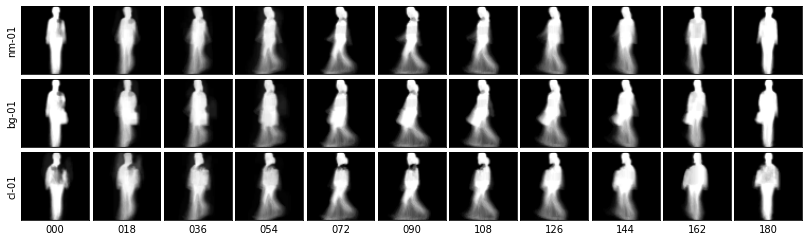

In [ ]:
subject = '012'
plot_subject(subject,'1',sviews,scondition,'Original_GEI')

# CONDITIONAL GAN

## Splitting the data
To train the GAN, it's necesary to arrange the data. Therefore, we are going to set the GEIs at all the viewpoints with clothing and carrying variations as the source and the GEIs of normal walking at 90° (side view) as the target for the first 62 subjects, as it is shown in the figure below.
<figure>
<center>
<img src='https://gitlab.com/IsRaTiAl/gait/raw/master/Images/Image2.svg'/>
<figcaption>Source and target images</figcaption></center>
</figure>

In [ ]:
import numpy as np
from os import listdir
import cv2
import os
from glob import glob
import time
t0 = time.clock()
import matplotlib.pyplot as plt

data_base = 'CASIA'
data_set = 'DatasetB'
data_set_rep = 'sil'
directorio = 'silhouettes'
condition = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
formato = '.png'
visualize = 0
slash='/'

count = 1
## Iterate through each subject
for subject in range(1,63):
  print('\rSubject:',subject,end='')
  subject = str(subject).zfill(3)

## Iterate through the normal conditions (Target images)
  for dom_con in condition[4:]:
    view = '090'
    slash='/'
    rep_sil = data_base+slash+data_set_rep+slash+subject+slash+dom_con+slash+view+slash+'1.png'
    GEI_dom = cv2.imread(rep_sil,0)
    
## Iterate through each condition (Source images)
    for i in range(len(condition)):
  ## Iterate through view
      for vi in range(11):
        view = str(vi*18).zfill(3)
        slash='/'
        rep_sil = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash+'1.png'
        GEI = cv2.imread(rep_sil,0)
        
        # Save the GEIs
        inputdata = "CASIA/pix2pix/inputdata/"
        targetdata = "CASIA/pix2pix/targetdata/"
        cv2.imwrite(inputdata+'s'+str(subject).zfill(3)+'_'+str(count).zfill(5)+'.png',GEI)
        cv2.imwrite(targetdata+'s'+str(subject).zfill(3)+'_'+str(count).zfill(5)+'.png',GEI_dom)

        count +=1
        if(visualize):
          f = plt.figure()
          f.add_subplot(1,2, 1)
          plt.imshow(GEI, cmap='gray')
          f.add_subplot(1,2, 2)
          plt.imshow(GEI_target,cmap='gray')
          plt.show(block=True)  
        if cv2.waitKey(50) & 0xff==27:
          break

print('\tTime: {} s'.format(round((time.clock()-t0),2)))

Subject: 62	Time: 15.54 s


Spliting the data. 90% -> Train 10% -> Test

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import matplotlib.pyplot as plt
import numpy as np

# Paths
PATH    = '/content/CASIA/pix2pix/'
inpath  = '/content/CASIA/pix2pix/inputdata'
outpath = '/content/CASIA/pix2pix/targetdata'

imgurls = !ls -1 "{inpath}"

np.random.seed(23)
np.random.shuffle(imgurls)

# imgurls = imgurls[:20000]
n = len(imgurls)
train_n = round(n*0.90)

# Lista random
randurls = np.copy(imgurls)

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print('Total images:',len(imgurls),' \nTraining:',len(tr_urls),' Testing:', len(ts_urls))

Total images: 40920  
Training: 36828  Testing: 4092


## Image augmentation
Here we are defining some functions that we are going to use later

In [ ]:
IMG_WIDTH = 64
IMG_HEIGHT = 64


# Resize images
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  return inimg, tgimg

# Normalize the pixel's values
def normalize(inimg, tgimg):
  inimg = (inimg/127) - 1
  tgimg = (tgimg/127) - 1
  return inimg, tgimg

@tf.function()
def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, int(IMG_WIDTH*1.02), int(IMG_HEIGHT*1.02))
  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,1])
  inimg, tgimg = cropped_image[0], cropped_image[1]
  return inimg, tgimg

@tf.function()
def load_image(filename, augment = True):
  inimg = tf.image.rgb_to_grayscale(tf.image.decode_png(tf.io.read_file(inpath+'/'+filename),channels=3))
  tgimg = tf.image.rgb_to_grayscale(tf.image.decode_png(tf.io.read_file(outpath+'/'+filename),channels=3))
  
  inimg, tgimg = resize(inimg,tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  inimg, tgimg = normalize(inimg, tgimg)
  return inimg, tgimg
  
def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

Let's try our function

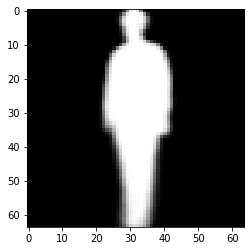

In [ ]:
inimg, tgimg = load_train_image('s001_00001.png')
plt.imshow(inimg.numpy()[:,:,0]*+1/2,cmap='gray')
plt.show()

We define two special functions (data generators), which we are going to use to train the model, but first, let's probe them and see some source-target samples.

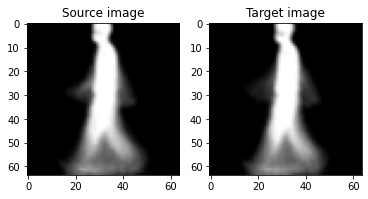

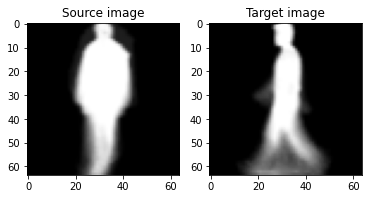

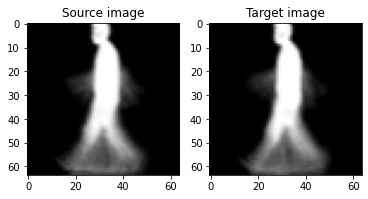

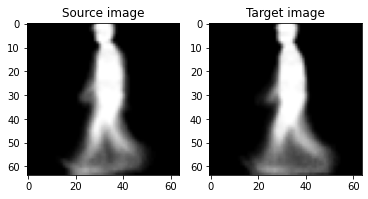

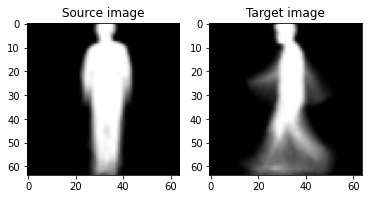

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image,num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(200)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image,num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(200)

for inimg, tgimg in train_dataset.take(5):
  f = plt.figure()
  f.add_subplot(1,2, 1)
  plt.title('Source image')
  plt.imshow((inimg[0,...,0]+1)/2,cmap='gray')
  f.add_subplot(1,2, 2)
  plt.title('Target image')
  plt.imshow((tgimg[0,...,0]+1)/2,cmap='gray')
  plt.show(block=True) 

## cGAN Model
First, we are going to define the basic blocks to build our model

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(Conv2D(filters, 
                    kernel_size = 4, 
                    strides=2, 
                    padding='same',
                    kernel_initializer=initializer, 
                    use_bias= not apply_batchnorm))

  if apply_batchnorm:
    result.add(BatchNormalization())

#   result.add(LeakyReLU())
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(Conv2DTranspose(filters, 
                             kernel_size = 4, 
                             strides=2, 
                             padding='same',
                             kernel_initializer=initializer, 
                             use_bias= False))
  result.add(BatchNormalization())
  if apply_dropout:
    result.add(Dropout(0.3))

  result.add(ReLU())
#   result.add(tf.keras.layers.LeakyReLU())

  return result

Once we have defined the downsample and upsample blocks, we can build the whole architecture of the Generator.

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,1])

  down_stack = [
    downsample(64, apply_batchnorm=False),                                      # (bs, 32, 32, 64)
    downsample(128),                                                            # (bs, 16, 16, 128)
    downsample(256),                                                            # (bs, 8,  4,  256)
    downsample(512),                                                            # (bs, 4,  4,  512)
  ]

  up_stack = [
    upsample(256, apply_dropout=True),                                          # (bs, 8,  8,  256)
    upsample(128, apply_dropout=False),                                         # (bs, 16, 16, 128)
    upsample(64, apply_dropout=False),                                          # (bs, 32, 32, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(filters = 1, 
                                         kernel_size = 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')                     # (bs, 64, 64, 1)

  concat = tf.keras.layers.Concatenate()
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Let's see what is generating our model, which has not been trained yet

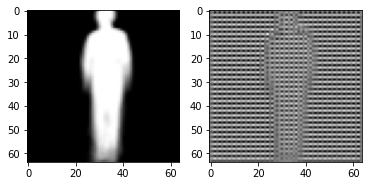

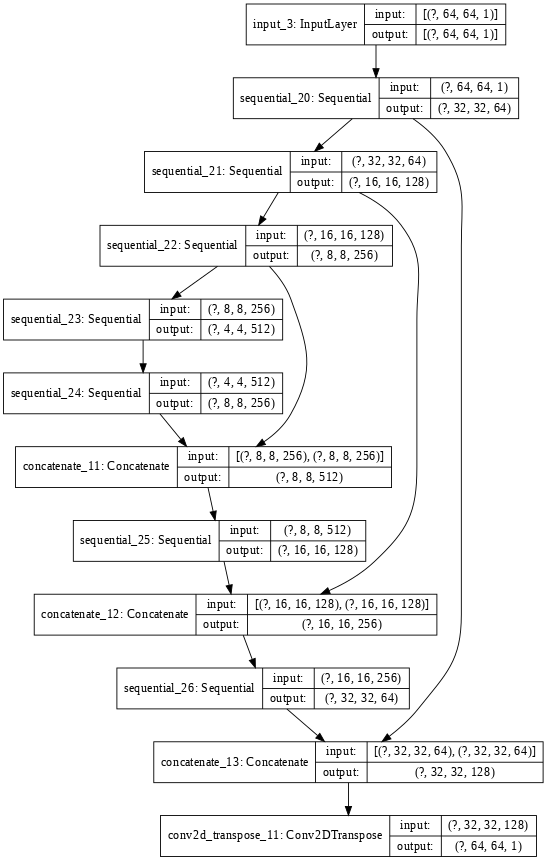

In [ ]:
generator = Generator()
gen_output = generator((inimg), training=False)
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow((inimg[0,...,0]+1)/2,cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow((gen_output[0,...,0]+1)/2,cmap='gray')
plt.show(block=True)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Here we are going to define the discriminator. This part of our model helps us to retain as much information as possible

In [ ]:
def Identificador_Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])                                   # (bs, 64, 64, 2)

  down1 = downsample(64, False)(x)                                              # (bs, 32, 32, 64)
  down2 = downsample(128)(down1)                                                # (bs, 16, 16, 128)
  down3 = downsample(256)(down2)                                                # (bs, 8,  8,  256)
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size = 4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding = 'valid',
                                activation='sigmoid')(down3)                    # (bs, 5, 5, 1)
  

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

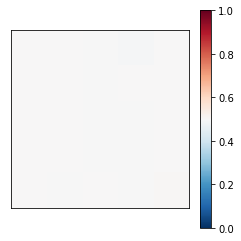

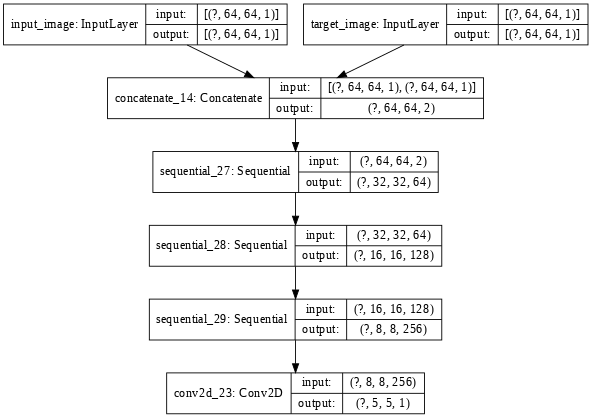

In [ ]:
idiscriminator= Identificador_Discriminator()
disc_out = idiscriminator([(inimg), gen_output], training=False)
plt.figure(figsize=(4,4))
plt.imshow(disc_out[0,...,0], vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
disc_out.shape

tf.keras.utils.plot_model(idiscriminator, show_shapes=True, dpi=64)

Now, the losses functions are going to be defined

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def idiscriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

LAMBDA = 400
def generator_loss(idisc_generated_output, gen_output, target):
  gan_loss1 = loss_object(tf.ones_like(idisc_generated_output), idisc_generated_output)
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss1 + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss1, l1_loss

We are going to use Adam as optimizer the generator and discriminator and set the learning rate at 0.0002 for both

In [ ]:
import os
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
idiscriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):
  prediction = model(test_input, training=True)
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH+'outputs/'+save_filename+'.jpg', prediction[0,...])
  
  plt.figure(figsize=(7,7))

  display_list = [test_input[0,...,], tar[0,...,], prediction[0,...,]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][...,0] * 0.5 + 0.5, cmap = 'gray')
    plt.axis('off')
  plt.show()

Here, we are defining a directory where the losses will be saved. Additionally, the training function is being defined.

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as idisc_tape, tf.GradientTape() as rfdisc_tape:
    gen_output = generator(input_image, training=True)

    idisc_real_output      = idiscriminator([input_image, target], training=True)
    idisc_generated_output = idiscriminator([input_image, gen_output], training=True)

    gen_loss,ganloss1,l1loss = generator_loss(idisc_generated_output, gen_output, target)
    idisc_loss = idiscriminator_loss(idisc_real_output, idisc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  idiscriminator_gradients = idisc_tape.gradient(idisc_loss, idiscriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  idiscriminator_optimizer.apply_gradients(zip(idiscriminator_gradients, idiscriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', ganloss1, step=epoch)
    tf.summary.scalar('gen_l1_loss', l1loss, step=epoch)
    tf.summary.scalar('idisc_loss', idisc_loss, step=epoch)


In [ ]:
from IPython.display import clear_output
import time

def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    imgi = 0
    for input_image, target in train_ds:
      print('\r','Epoch: '+str(epoch)+' - train: '+str(imgi)+'/'+str(len(tr_urls)),end='')
      imgi +=1
      train_step(input_image, target, epoch)

    imgi = 0
    for example_input, example_target in test_ds.take(3):
      generate_images(generator, example_input, example_target, str(imgi)+'_'+str(epoch), display_imgs=True)
      imgi +=1

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

Let's train our model for 20 epochs, which is enough to achieve good results according to our experiments.

 Epoch: 0 - train: 184/36828

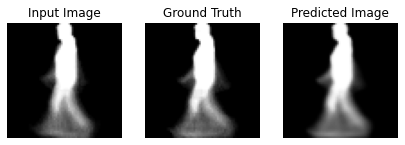

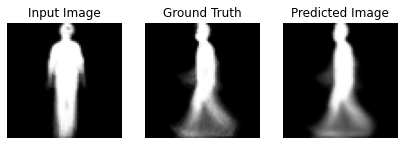

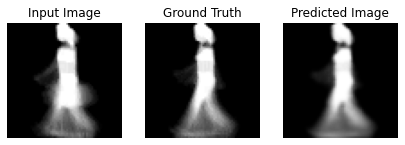

Time taken for epoch 1 is 93.91180491447449 sec

 Epoch: 1 - train: 184/36828

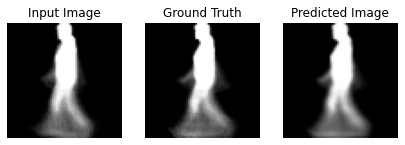

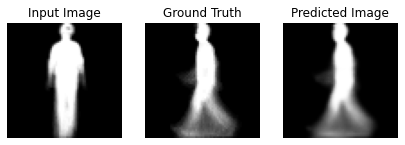

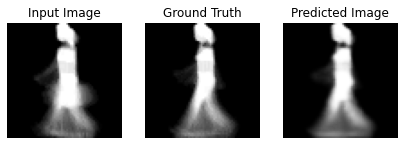

Time taken for epoch 2 is 94.27675080299377 sec

 Epoch: 2 - train: 184/36828

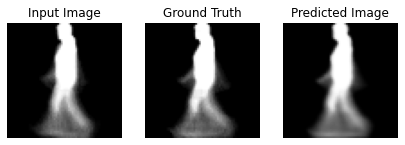

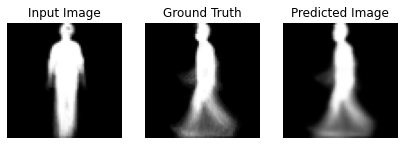

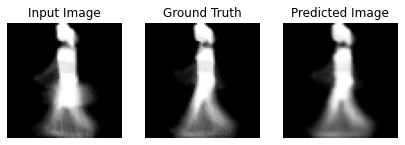

Time taken for epoch 3 is 94.07981610298157 sec

 Epoch: 3 - train: 184/36828

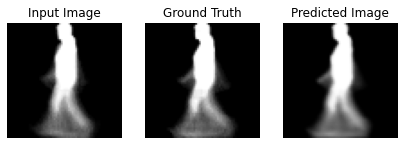

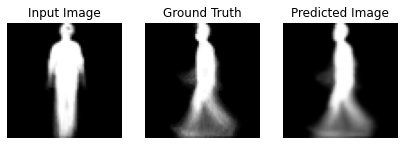

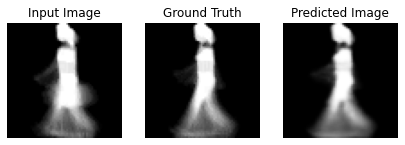

Time taken for epoch 4 is 94.12657022476196 sec

 Epoch: 4 - train: 184/36828

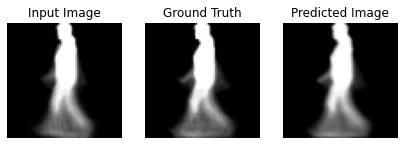

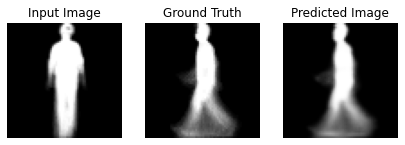

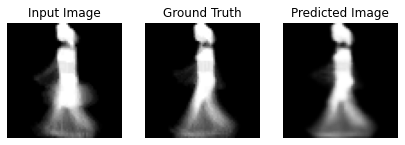

Time taken for epoch 5 is 94.11042642593384 sec

 Epoch: 5 - train: 184/36828

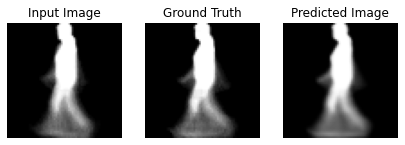

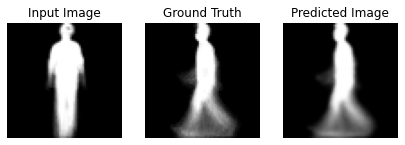

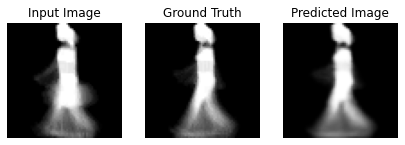

Time taken for epoch 6 is 93.41780853271484 sec

 Epoch: 6 - train: 184/36828

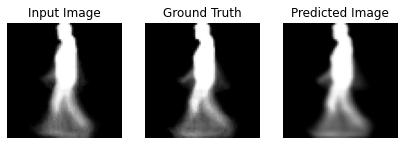

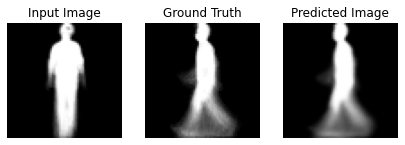

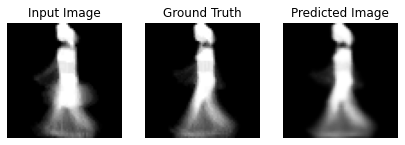

Time taken for epoch 7 is 92.821852684021 sec

 Epoch: 7 - train: 184/36828

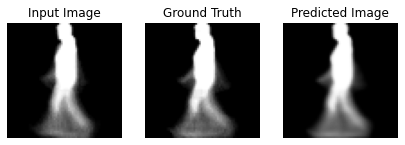

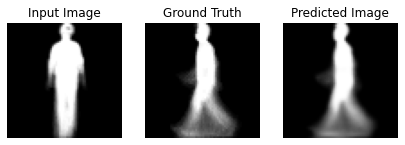

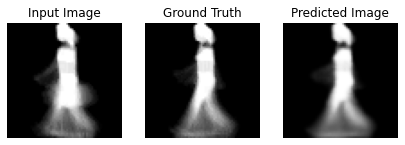

Time taken for epoch 8 is 92.90334987640381 sec

 Epoch: 8 - train: 184/36828

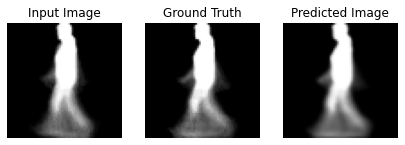

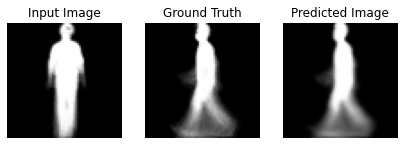

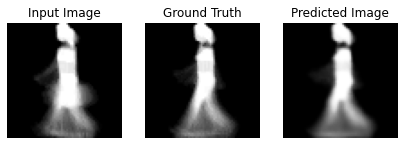

Time taken for epoch 9 is 92.61615228652954 sec

 Epoch: 9 - train: 184/36828

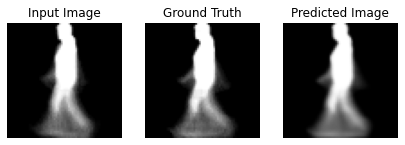

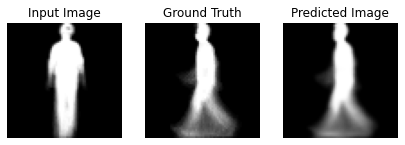

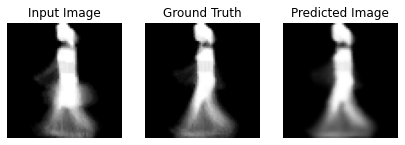

Time taken for epoch 10 is 92.61401152610779 sec



In [ ]:
EPOCHS = 10
fit(train_dataset, EPOCHS, test_dataset)

## Testing
Now that the model has been trained. Let's define the functions that will be used to test its performance on new data.

We are going to convert all the images of walking sequences with clothing and carrying variations at any view to normal walking at 90° view for subjects 63 to 124.

In [ ]:
idrange = [63,125]
def transf(name):
  img = tf.image.rgb_to_grayscale(tf.image.resize((tf.image.decode_png(tf.io.read_file(name),channels=3)),(64, 64)))
  img = img[np.newaxis]/127-1
  pred = np.array(255*((generator(img,training = False)[0]+1)/2))
  return pred

In [ ]:
import numpy as np
from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
t0 = time.clock()

data_base = 'CASIA'
data_set = 'DatasetB' 
data_set_rep = 'sil'
data_train = 'data'
directorio = 'silhouettes'	

train_   = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
view = '090'	
formato = '.png'


data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_

def transform_data(verbose=True):
  for subject in range(idrange[0],idrange[1]):
    subject = str(subject).zfill(3)
    if verbose:
      print('\r', 'Subject: ',subject, end='')
    for dset in data:
      condition = data[dset]
      for cond in condition:
        for view in range(11):
          view = str(view*18).zfill(3)
          GEI_path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+'1.png'                 #CASIA/sil/104/nm-04/090/1.png
          GEI_save_path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+file_name+'.png'   #CASIA/sil/104/nm-04/090/4.png
          GEI = transf(GEI_path)
          cv2.imwrite(GEI_save_path,GEI)
  if verbose:
    print("\tTransform_data: ",str(time.clock()-t0))

Here, we are arranging the converted images into training and testing sets

In [ ]:
import numpy as np
from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
t0 = time.clock()

data_base = 'CASIA'
data_set = 'DatasetB' 
data_set_rep = 'sil'
data_train = 'data'
directorio = 'silhouettes'	
views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
train_ = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
formato = '.png'


data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_


def split_flat(verbose=True):
  t0 = time.clock()
  for view in views:
    if verbose: 
      print('View: ', str(view))
  #   view = str(view*18).zfill(3)
    for dset in data:
      if verbose: 
        print(dset, ':',data[dset])
      condition = data[dset]
      matriz  = []
      etiqueta = []
      c1 =0
      for subject in range(idrange[0], idrange[1]):
        subject = str(subject).zfill(3)
  #       print('Subject: ', subject)
        for i in range(len(condition)):
          # Definimos el nombre de la imagen
          read_gei = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash+file_name+'.png'
          img = cv2.imread(read_gei,0)
  #         img[int(x1*0.12):int(x1*0.68),0:y1]=0

          try:
            matriz.append(img.flatten())
            etiqueta.append(int(subject))
          except:
            print('Error saving:', read_gei)

          if cv2.waitKey(1) & 0xff==27:
            break

      matriz = np.array(matriz)
      etiqueta = np.array(etiqueta)[np.newaxis].T
      directory_data = data_base+slash+data_train+slash+view+slash
      if not os.path.exists(directory_data):
          os.makedirs(directory_data)
      np.savetxt(directory_data+dset+'data.dat', matriz)
      np.savetxt(directory_data+dset+'target.dat', etiqueta)
      if verbose:
        print(dset,'data.dat-> ',matriz.shape)
        print(dset,'data.dat-> ',etiqueta.shape)

  cv2.destroyAllWindows()
  if verbose:
    print(str(time.clock()-t0))



 We have used the six normal walking sequences, two sequences with coat and two sequences containing walking with a bag of the first 62 subjects to train the GAN. The remaining 62 subjects will be used as the test set. In the test set, the first 4 normal walking sequences of each subjects are put into the gallery set and the others into the probe set as it is shown in Table.

In [ ]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm


def normalizacion(data):
	u = np.mean(data,axis=0)
	s = np.std(data,axis=0)
	data = (data - u)/s
	return (data,u,s)
def normalizacion2(data,u,s):
	data = (data - u) / s
	return data

datasets = ['test_nm_','test_bg_','test_cl_']
data_base = 'CASIA'
data_train = 'data'
slash = '/'

CCR_nm = np.zeros((11,11))
CCR_bg = np.zeros((11,11))
CCR_cl = np.zeros((11,11))

def test_model(iteration):



  for view_g,galery_view in enumerate(views):
    # Cargamos la base de datos
    carpeta = data_base+slash+data_train+slash+galery_view+slash

    trainX = np.loadtxt(carpeta+'train_data.dat')

    # Escalamos los datos
    scaler = StandardScaler()
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)

    trainY = np.loadtxt(carpeta+'train_target.dat')

    _ ,componentes_original = trainX.shape

    # Aplicamos PCA
    pre = 0.9999
    pca = PCA(pre)
    pca.fit(trainX)
    componentes_PCA = pca.n_components_
    trainX = pca.transform(trainX)

    logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
    logisticRegr.fit(trainX, trainY)


    # Calculamos su score
    score = logisticRegr.score(trainX, trainY)
    print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4), 'Angle:', galery_view)
    # Realizamos pruebas en los datasets de testeo
    for view_p,prove_view in enumerate(views):
      carpeta_p = data_base+slash+data_train+slash+prove_view+slash
      for i in range(len(datasets)):
        testX = np.loadtxt(carpeta_p+datasets[i]+'data.dat')
        testX = scaler.transform(testX)
        # testX = normalizacion2(testX,mean,st)
        testX = pca.transform(testX)
        testY = np.loadtxt(carpeta_p+datasets[i]+'target.dat')

        # Calculamos su score
        score = logisticRegr.score(testX, testY)
        certeza = logisticRegr.predict(testX)

        # Mostramos la matriz de confusion
        # print(confusion_matrix(certeza,testY))
        if(i==0):
          CCR_nm[view_g,view_p] = np.round(score*100,2)
        if(i==1):
          CCR_bg[view_g,view_p] = np.round(score*100,2)
        if(i==2):
          CCR_cl[view_g,view_p] = np.round(score*100,2)

      print('Prove view:', prove_view, '\tnm: ',CCR_nm[view_g,view_p],'\tbg: ',CCR_bg[view_g,view_p],'\tcl: ',CCR_cl[view_g,view_p])


  print(str(iteration)+'T Test:1-62',np.round(CCR_nm.mean(),2),'-',np.round(CCR_bg.mean(),2),'-',np.round(CCR_cl.mean(),2))
  print(str(iteration)+'T Test:63-124',np.round(CCR_nm.mean(),2),'-',np.round(CCR_bg.mean(),2),'-',np.round(CCR_cl.mean(),2))

In [ ]:
file_name='2'
transform_data(verbose=True)
split_flat(verbose=False)
test_model('30')

 Subject:  124	Transform_data:  135.4783320000024
Dataset: Train  shape test:  (248, 236)  correcto:  1.0 Angle: 000
Prove view: 000 	nm:  99.19 	bg:  87.1 	cl:  45.16
Prove view: 018 	nm:  67.74 	bg:  45.97 	cl:  27.42
Prove view: 036 	nm:  46.77 	bg:  29.84 	cl:  21.77
Prove view: 054 	nm:  29.03 	bg:  18.55 	cl:  14.52
Prove view: 072 	nm:  23.39 	bg:  14.52 	cl:  6.45
Prove view: 090 	nm:  18.55 	bg:  15.32 	cl:  9.68
Prove view: 108 	nm:  18.55 	bg:  11.29 	cl:  6.45
Prove view: 126 	nm:  28.23 	bg:  15.32 	cl:  10.48
Prove view: 144 	nm:  30.65 	bg:  18.55 	cl:  20.97
Prove view: 162 	nm:  47.58 	bg:  33.87 	cl:  25.0
Prove view: 180 	nm:  68.55 	bg:  52.42 	cl:  30.65
Dataset: Train  shape test:  (248, 237)  correcto:  1.0 Angle: 018
Prove view: 000 	nm:  80.65 	bg:  56.45 	cl:  28.23
Prove view: 018 	nm:  99.19 	bg:  86.29 	cl:  49.19
Prove view: 036 	nm:  93.55 	bg:  68.55 	cl:  45.16
Prove view: 054 	nm:  62.9 	bg:  45.16 	cl:  28.23
Prove view: 072 	nm:  48.39 	bg:  26.61 	c

Let's visualize some converted images.

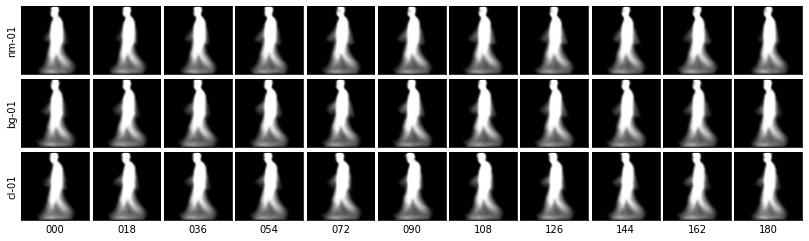

In [ ]:
plot_subject('120', file_name, views, scondition,'124')

# RESULTS
As can be seen above, the generator has learned to transform GEIs at any view to side view. However, it is necessary to measure its performance using an appropriate metric.The metric we are going to use is the correct classification rate (CCR) that corresponds to the ratio of the number of correctly classified samples over the total number of samples

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def GAN_scores(variation,file):
  CCR_pd = pd.read_excel('gait/CCR/'+file+'.xlsx', sheet_name=variation,header=None, columns=views)
  return np.array(CCR_pd)

files = ['GaitGan','GaitGan2','SPAE','PCA_KNN']

nm_GAN = GAN_scores('nm',files[1])
bg_GAN = GAN_scores('bg',files[1])
cl_GAN = GAN_scores('cl',files[1])


## Our results
The following tables show the CCR achieved by our model. In each table, each row corresponds to a view angle of the gallery set, whereas each column corresponds to the view angle of the probe set. Since there are 11 views in the database, there are 121 pairs of combinations.


In [ ]:
import pandas as pd
print('\t    | NORMAL WALKING | ROWS = GALLERY | COLUMNS = PROVE |')
pd.DataFrame(data=CCR_nm, columns=views, index=views)

	    | NORMAL WALKING | ROWS = GALLERY | COLUMNS = PROVE |


,000,018,036,054,072,090,108,126,144,162,180
000,99.19,67.74,46.77,29.03,23.39,18.55,18.55,28.23,30.65,47.58,68.55
018,80.65,99.19,93.55,62.90,48.39,35.48,33.06,43.55,45.16,66.13,50.81
036,48.39,91.94,96.77,86.29,69.35,54.84,58.06,62.10,66.94,57.26,28.23
054,34.68,59.68,91.13,97.58,92.74,89.52,83.06,82.26,66.13,39.52,24.19
072,16.94,35.48,66.13,93.55,99.19,97.58,93.55,77.42,55.65,30.65,12.90
090,20.16,37.90,54.03,77.42,98.39,99.19,97.58,83.06,58.06,32.26,20.16
108,24.19,39.52,55.65,81.45,93.55,95.97,99.19,92.74,82.26,39.52,26.61
126,22.58,45.97,59.68,75.00,81.45,83.87,93.55,97.58,95.16,56.45,25.00
144,32.26,45.97,60.48,61.29,62.90,59.68,82.26,94.35,98.39,77.42,41.13
162,63.71,61.29,62.10,50.81,34.68,35.48,48.39,66.13,77.42,99.19,71.77


In [ ]:
print('\t    | CARRYING WALKING | ROWS = GALLERY | COLUMNS = PROVE |')
pd.DataFrame(data=CCR_bg, columns=views, index=views)

	    | CARRYING WALKING | ROWS = GALLERY | COLUMNS = PROVE |


,000,018,036,054,072,090,108,126,144,162,180
000,87.10,45.97,29.84,18.55,14.52,15.32,11.29,15.32,18.55,33.87,52.42
018,56.45,86.29,68.55,45.16,26.61,20.97,19.35,30.65,32.26,45.97,29.84
036,32.26,74.19,83.06,67.74,51.61,37.10,32.26,42.74,46.77,39.52,21.77
054,24.19,49.19,76.61,85.48,83.06,62.90,61.29,61.29,46.77,29.84,19.35
072,18.55,30.65,53.23,75.81,91.13,79.84,73.39,59.68,38.71,26.61,18.55
090,15.32,25.81,42.74,66.13,82.26,75.81,79.03,64.52,40.32,22.58,12.90
108,16.13,31.45,45.97,64.52,77.42,74.19,83.06,76.61,56.45,29.84,13.71
126,15.32,29.84,41.13,55.65,64.52,58.87,71.77,84.68,68.55,34.68,17.74
144,26.61,37.90,33.87,42.74,43.55,41.94,54.03,76.61,82.26,51.61,30.65
162,45.97,37.90,34.68,29.03,29.03,26.61,30.65,36.29,52.42,85.48,52.42


In [ ]:
print('\t    | CLOTHING WALKING | ROWS = GALLERY | COLUMNS = PROVE |')
pd.DataFrame(data=CCR_cl, columns=views, index=views)

	    | CLOTHING WALKING | ROWS = GALLERY | COLUMNS = PROVE |


,000,018,036,054,072,090,108,126,144,162,180
000,45.16,27.42,21.77,14.52,6.45,9.68,6.45,10.48,20.97,25.00,30.65
018,28.23,49.19,45.16,28.23,20.97,19.35,17.74,24.19,29.84,30.65,21.77
036,24.19,41.13,58.06,49.19,31.45,23.39,21.77,27.42,35.48,22.58,13.71
054,12.10,20.97,45.16,58.87,52.42,41.13,33.06,28.23,25.81,16.13,12.10
072,20.97,22.58,35.48,45.97,61.29,53.23,43.55,31.45,25.81,16.94,8.87
090,14.52,19.35,31.45,41.13,58.06,50.00,47.58,44.35,25.81,21.77,9.68
108,15.32,18.55,37.10,41.94,58.06,51.61,59.68,53.23,43.55,28.23,15.32
126,19.35,21.77,32.26,40.32,38.71,40.32,42.74,54.84,45.97,24.19,12.90
144,23.39,22.58,32.26,32.26,31.45,29.84,39.52,50.81,58.87,40.32,19.35
162,18.55,16.13,19.35,22.58,19.35,12.10,16.94,23.39,29.84,41.94,19.35


## Comparison with the state-of-the-art
To fairly illustrate the performance of the proposed method, we also compare our method against the reported by other state-of-the-art methods when the gallery images are different from those in the prove set, and when they are the same. we compare our method with [GEI+PCA](https://ieeexplore.ieee.org/document/1561189) , [SPAE](https://ieeexplore.ieee.org/document/7899748), [GaitGANv1](https://ieeexplore.ieee.org/document/8014814), and [GaitGANv2](https://www.sciencedirect.com/science/article/abs/pii/S0031320318303649). 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def GAN_scores(file, variation):
  CCR_pd = pd.read_excel('gait/CCR/'+file+'.xlsx', sheet_name=variation,header=None, columns=views)
  return np.array(CCR_pd)

views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
files = ['GaitGan','GaitGan2','SPAE','PCA_KNN']
covariates = ['nm','bg','cl']
Scores = {}

for file in files:
  for var in covariates:
    Scores[file+'_'+var] = GAN_scores(file, var)
    
Scores['Ours_nm']=CCR_nm
Scores['Ours_bg']=CCR_bg
Scores['Ours_cl']=CCR_cl

In [ ]:
nviews = np.arange(0, 181, 18)
color = ['b','g','r','c','m']
markers = ['s','D','^','p']
def plot_set(files, cset,idview):
  for i, file in enumerate(files):
    plt.plot(nviews, Scores[file+'_'+cset][:,idv],color[i]+markers[i]+'-', label=file)
#   plt.plot(nviews, GG_set[cset][:,idview],'gs-',label='GaitGan')
  
  plt.title('Prove '+str(cset)+' Angle '+str(int(views[idview]))+'°',color='gray')
  plt.xlabel('Galery angles',color='gray')
  plt.xticks(np.arange(0, 181, 18),color='gray')
  plt.yticks(np.arange(0, 101, 10),color='gray')
  plt.grid('minor',linestyle=':', linewidth=0.5)
  plt.legend()
  plt.ylabel('CCR(%)',color='gray')


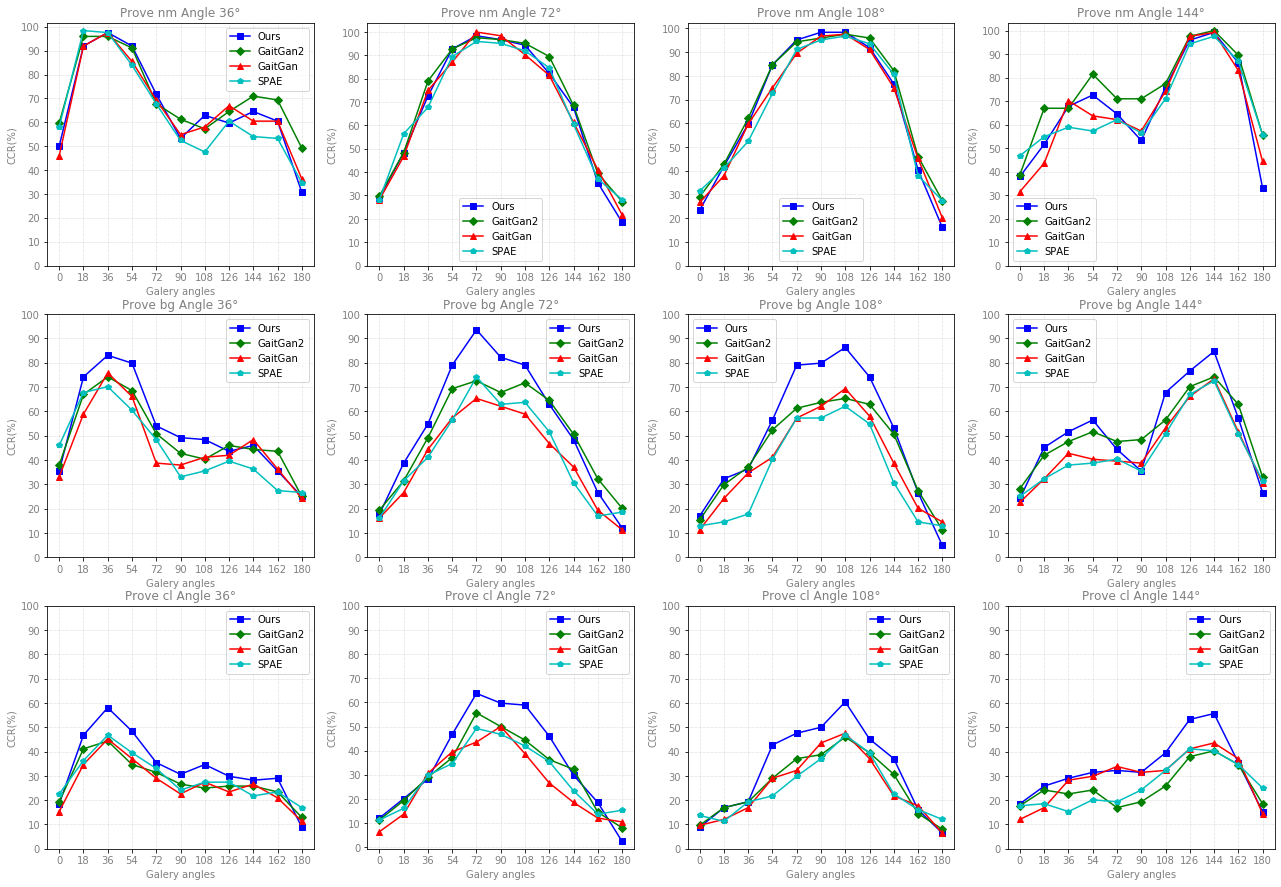

In [ ]:
plot_views = [36,72,108,144]
plt.figure(figsize=(22,3.8*len(plot_views)))
files = ['Ours','GaitGan2','GaitGan','SPAE','PCA_KNN']

for i, cov in enumerate(covariates):
  for j, idv in enumerate(plot_views):
    idv = np.where((views.astype(int))==idv)[0][0]
    plt.subplot(len(covariates), len(plot_views),1+j+i*len(plot_views))
    plot_set(files[:4], cov, idv)
plt.savefig("test1.svg")

Additionally, we compared the recognition rates without view changes. To compute this, we averaged the CCRs on the main diagonal of Tables, which correspond to the recognition rates without view changes. The corresponding average rates of GEI+PCA, SPAE, GaitGANv1, and GaitGANv2 were obtained from their respective works. 

In [ ]:
from matplotlib.ticker import NullFormatter

def mean_score(scores):
  return round(np.sum(np.multiply(np.eye(11),scores))/11,1)

def cross_mean_score(scores):
  return round(np.sum(np.multiply(np.ones((11,11))-np.eye(11),scores))/110,2)

labels = ['nm','bg','cl']
width = 0.50
def bar_plot(Scores, files, function, save_name):
  fig, ax = plt.subplots(figsize=(7, 3))
  ax.yaxis.grid('both',linestyle='solid', linewidth=0.9,zorder=0) # horizontal lines
  nfiles = len(files)
  x = np.arange(len(labels))*nfiles*width*1.3
  for i, file in enumerate(files):
    scores = [function(Scores[file+'_nm']), function(Scores[file+'_bg']), function(Scores[file+'_cl'])]
    rec = (ax.bar(x + width*i*1.07-(width*(nfiles/2.45)), scores, width, label=file, zorder=3))
    for rect in rec:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
  
  ax.set_ylabel('Recognition rate (%)')
  ax.set_xticks(x)
  ax.set_yticklabels([])
  ax.tick_params(grid_alpha=0.5)
  ax.set_xticklabels(labels)
  ax.legend()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  fig.tight_layout()
  plt.show()
  fig.savefig(save_name+".svg")

files = ['Ours','GaitGan2','GaitGan','SPAE','PCA_KNN']


Comparison of CCR with some state-of-the-art methods without view variations at three different conditions.

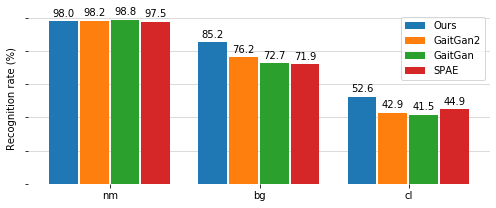

In [ ]:
bar_plot(Scores, files[:4], mean_score,'main_diagonal')

We carried out a similar experiment; however, this time, to compute the CCR, we averaged all the results of Tables excepting those of the main diagonal. 

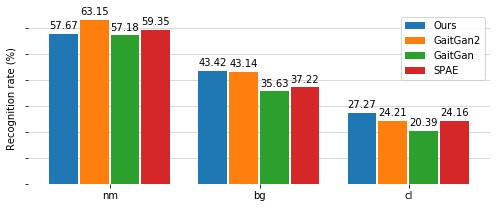

In [ ]:
bar_plot(Scores, files[:4], cross_mean_score,'cross_view')

## Conclusions
In this work:
-	We propose to use a combined cross-view gait recognition approach by using a generative model to produce side-view gait energy images and utilize a discriminative model for the classification task.
-	We provide an extensive experimental evaluation of the proposed model, which is designed to address appearance changes due to changes in the view.

The proposed framework achieves a superior performance among the approaches which focus on the same issue. This is verified by experiments, which show that the proposed method outperforms state-of-the-art methods, especially in the case of carrying-bag and clothing-coat variations, which is very suitable for practical applications such as intelligent surveillance systems.

In the future, we are going to implement more complex and powerful models to deal with cross-view recognition.